In [34]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Import all game stats from json file
# IMPORTANT NOTE, MUST INCLUDE THE slippi_games.json FILE FOR THE DATA

stats_json = ""
with open("slippi_games.json", mode="r", encoding="utf-8") as file:
    stats_json = file.read()
stats = json.loads(stats_json)

In [36]:
# Function to detect a winner in each game

def detect_winner(game):
    p1_index = game['settings']['players'][0]['playerIndex']
    winner_idx = None
    for i, stock in enumerate(game['stats']['stocks']):
        endFrame = stock['endFrame']
        if endFrame != None:
            winner_idx = game['stats']['stocks'][i]['playerIndex']
    if winner_idx == p1_index:
        return 0
    else:
        return 1

print(detect_winner(stats[1]))

0


In [37]:
# features: extract stats from games and create features

for group in stats[0]:
    print(f'{group}: \n --------------')
    for stat in stats[0][group]:
        print(stat)
    print()

X = []
y = []

def is_real_match(game_instance):
    zero_percent_stocks = [item for item in game_instance['stats']['stocks'] if item['endPercent'] == 0]
    return len(zero_percent_stocks) > 2

for game_index, game in enumerate(stats):
    # exclude unfinished games
    if len(game['stats']['stocks']) < 4 :
        continue

    p1_index = game['settings']['players'][0]['playerIndex']
    winner = detect_winner(game)
    if len(game['winners']) == 0:
        continue
    else:
        if game['winners'][0]['playerIndex'] == p1_index:
            winner = 0
        else:
            winner = 1

    y.append(winner)

    feature_names = ['p1_totalDamage','p1_inputsPerMinute','p1_openingsPerKill','p1_damagePerOpening',
                     'p1_neutralWinRatio','p1_counterHitRatio', 'p1_lcancel_ratio','p2_totalDamage','p2_inputsPerMinute','p2_openings_per_kill','p2_neutralWinRatio','p2_counterHitRatio']

    # features for 1 game
    features = []

    p1_overall = game['stats']['overall'][0]
    p2_overall = game['stats']['overall'][1]
    p1_actionCounts = game['stats']['actionCounts'][0]
    p2_actionCounts = game['stats']['actionCounts'][1]

    # player 1 stats
    p1_character = game['settings']['players'][0]['characterId']
    p1_kill_count = p1_overall['killCount']
    p1_total_damage = p1_overall['totalDamage']
    p1_successful_conversions_ratio = p1_overall['successfulConversions']['ratio']
    p1_inputs_per_minute = p1_overall['inputsPerMinute']['ratio']
    p1_openings_per_kill = p1_overall['openingsPerKill']['ratio']
    p1_damage_per_opening = p1_overall['damagePerOpening']['ratio']
    p1_neutral_win_ratio = p1_overall['neutralWinRatio']['ratio']
    p1_counter_hit_ratio = p1_overall['counterHitRatio']['ratio']
    p1_lcancel_ratio = p1_actionCounts['lCancelCount']['success'] / (p1_actionCounts['lCancelCount']['success'] + p1_actionCounts['lCancelCount']['fail']) if p1_actionCounts['lCancelCount']['fail'] != 0 else 1


    # player 2 stats
    p2_character = game['settings']['players'][1]['characterId']
    p2_kill_count = p2_overall['killCount']
    p2_total_damage = p2_overall['totalDamage']
    p2_successful_conversions_ratio = p2_overall['successfulConversions']['ratio']
    p2_inputs_per_minute = p2_overall['inputsPerMinute']['ratio']
    p2_openings_per_kill = p2_overall['openingsPerKill']['ratio']
    p2_damage_per_opening = p2_overall['damagePerOpening']['ratio']
    p2_neutral_win_ratio = p2_overall['neutralWinRatio']['ratio']
    p2_counter_hit_ratio = p2_overall['counterHitRatio']['ratio']
    p2_lcancel_ratio = p2_actionCounts['lCancelCount']['success'] / (p2_actionCounts['lCancelCount']['success'] + p2_actionCounts['lCancelCount']['fail']) if p2_actionCounts['lCancelCount']['fail'] != 0 else 1

    # features.append(p1_kill_count)
    # features.append(p2_kill_count)
    features.append(p1_total_damage)
    features.append(p1_inputs_per_minute)
    features.append(p1_openings_per_kill)
    features.append(p1_neutral_win_ratio)
    features.append(p1_counter_hit_ratio)
    features.append(p1_lcancel_ratio)
    features.append(p2_total_damage)
    features.append(p2_inputs_per_minute)
    features.append(p2_openings_per_kill)
    features.append(p2_neutral_win_ratio)
    features.append(p2_counter_hit_ratio)
    features.append(p2_lcancel_ratio)

    # make sure that "null" stats are set to 0
    for i, feature in enumerate(features):
        if feature is None:
            features[i] = 0


    X.append(features)




winners: 
 --------------

settings: 
 --------------
slpVersion
timerType
inGameMode
friendlyFireEnabled
isTeams
itemSpawnBehavior
stageId
startingTimerSeconds
enabledItems
players
scene
gameMode
language
gameInfoBlock
randomSeed
isPAL
isFrozenPS
matchInfo

metadata: 
 --------------
startAt
lastFrame
consoleNick
players
playedOn

stats: 
 --------------
lastFrame
playableFrameCount
stocks
conversions
combos
actionCounts
overall
gameComplete



In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [40]:
print(len(X))

2815


In [66]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.decomposition import PCA

stdScaler = StandardScaler()
minMax = MinMaxScaler()
pca = PCA(n_components=2)

X_train_scaled = stdScaler.fit_transform(X_train)
X_test_scaled = stdScaler.transform(X_test)
X_val_scaled = stdScaler.transform(X_val)

X_train_mm = minMax.fit_transform(X_train)
X_test_mm = minMax.transform(X_test)
X_val_mm = minMax.transform(X_val)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)


Training accuracy
0.8805528134254689
Validation accuracy
0.8938053097345132
Test accuracy
0.8685612788632326


Text(0.5, 25.52222222222222, 'Predicted Winner')

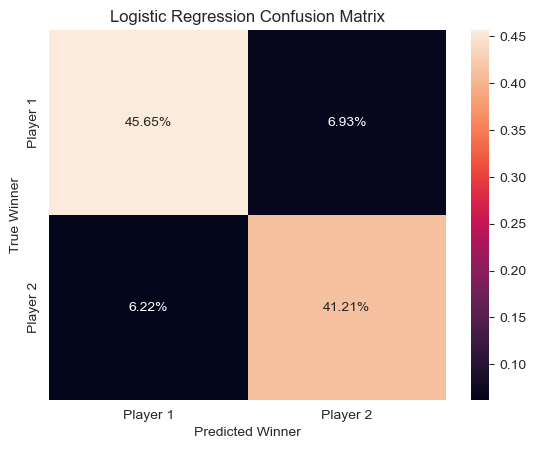

In [42]:
log = LogisticRegression()
log.fit(X_train_scaled, y_train)
log_train_score = log.score(X_train_scaled, y_train)
log_validation_score = log.score(X_val_scaled, y_val)
log_test_score = log.score(X_test_scaled, y_test)
print('Training accuracy')
print(log_train_score)
print('Validation accuracy')
print(log_validation_score)
print('Test accuracy')
print(log_test_score)

# plot confusion matrix
y_pred = log.predict(X_test_scaled)
confusion_matrix_log = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.title('Logistic Regression Confusion Matrix')
x_labels = ['Player 1', 'Player 2']
y_labels = ['Player 1', 'Player 2']
sns.heatmap(confusion_matrix_log / np.sum(confusion_matrix_log), fmt='.2%', annot=True, xticklabels=x_labels, yticklabels=y_labels)
plt.ylabel('True Winner')
plt.xlabel('Predicted Winner')

In [44]:
gradBoost = GradientBoostingClassifier(n_estimators=40, learning_rate=0.1)
gradBoost.fit(X_train_scaled, y_train)
gradBoost_train_score = gradBoost.score(X_train_scaled, y_train)
gradBoost_validation_score = gradBoost.score(X_val_scaled, y_val)
gradBoost_test_score = gradBoost.score(X_test_scaled, y_test)
print('Training accuracy')
print(gradBoost_train_score)
print('Validation accuracy')
print(gradBoost_validation_score)
print('Test accuracy')
print(gradBoost_test_score)

Training accuracy
0.928923988153998
Validation accuracy
0.9070796460176991
Test accuracy
0.8934280639431617


Training accuracy
0.9081934846989141
Validation accuracy
0.8893805309734514
Test accuracy
0.8863232682060391


Text(0.5, 25.52222222222222, 'Predicted Winner')

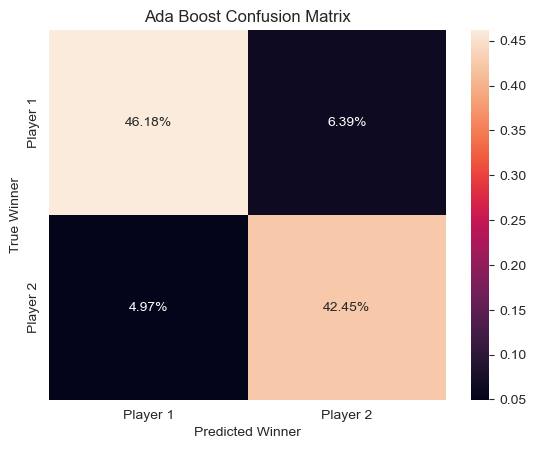

In [45]:
adaBoost = AdaBoostClassifier(n_estimators=100, learning_rate=0.2)
adaBoost.fit(X_train_scaled, y_train)
adaBoost_train_score = adaBoost.score(X_train_scaled, y_train)
adaBoost_validation_score = adaBoost.score(X_val_scaled, y_val)
adaBoost_test_score = adaBoost.score(X_test_scaled, y_test)
print('Training accuracy')
print(adaBoost_train_score)
print('Validation accuracy')
print(adaBoost_validation_score)
print('Test accuracy')
print(adaBoost_test_score)

# plot confusion matrix
y_pred = adaBoost.predict(X_test_scaled)
confusion_matrix_ada = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.title('Ada Boost Confusion Matrix')
x_labels = ['Player 1', 'Player 2']
y_labels = ['Player 1', 'Player 2']
sns.heatmap(confusion_matrix_ada / np.sum(confusion_matrix_ada), fmt='.2%', annot=True, xticklabels=x_labels, yticklabels=y_labels)
plt.ylabel('True Winner')
plt.xlabel('Predicted Winner')


In [46]:
# decision tree and forest tree models

print('decision tree')
decision = DecisionTreeClassifier(random_state=42, max_depth=5, max_features=5)
decision.fit(X_train_scaled, y_train)
decision_train_score = decision.score(X_train_scaled, y_train)
decision_validation_score = decision.score(X_val_scaled, y_val)
decision_test_score = decision.score(X_test_scaled, y_test)
print('Training accuracy')
print(decision_train_score)
print('Validation accuracy')
print(decision_validation_score)
print('Test accuracy')
print(decision_test_score)

print('\nforest')
forest = RandomForestClassifier(n_estimators=50, max_depth=5, max_features=3, random_state=42, n_jobs=-1)
forest.fit(X_train_scaled, y_train)
forest_train_score = forest.score(X_train_scaled, y_train)
forest_validation_score = forest.score(X_val_scaled, y_val)
forest_test_score = forest.score(X_test_scaled, y_test)
print('Training accuracy')
print(forest_train_score)
print('Validation accuracy')
print(forest_validation_score)
print('Test accuracy')
print(forest_test_score)

print()
top_features = np.argsort(decision.feature_importances_)
print('Feature importance of decison tree model (feature: percent used to split)')
for i, feature in enumerate(reversed(top_features[-5:])):
    print(f'{i + 1}. {feature_names[feature]}: {decision.feature_importances_[feature]:.2f}')
print()

print()
top_features_forest = np.argsort(forest.feature_importances_)
print('Feature importance of random forest model (feature: percent used to split)')
for i, feature in enumerate(reversed(top_features_forest[-5:])):
    print(f'{i + 1}. {feature_names[feature]}: {forest.feature_importances_[feature]:.2f}')
print()



decision tree
Training accuracy
0.8963474827245804
Validation accuracy
0.8849557522123894
Test accuracy
0.8436944937833037

forest
Training accuracy
0.9254689042448174
Validation accuracy
0.8805309734513275
Test accuracy
0.8827708703374778

Feature importance of decison tree model (feature: percent used to split)
1. p2_inputsPerMinute: 0.39
2. p1_openingsPerKill: 0.35
3. p1_totalDamage: 0.12
4. p1_lcancel_ratio: 0.04
5. p1_damagePerOpening: 0.03


Feature importance of random forest model (feature: percent used to split)
1. p1_openingsPerKill: 0.28
2. p2_inputsPerMinute: 0.25
3. p1_lcancel_ratio: 0.15
4. p1_totalDamage: 0.13
5. p2_openings_per_kill: 0.06



Training accuracy
0.9486673247778875
Validation accuracy
0.9070796460176991
Test accuracy
0.9040852575488455


Text(0.5, 25.52222222222222, 'Predicted Winner')

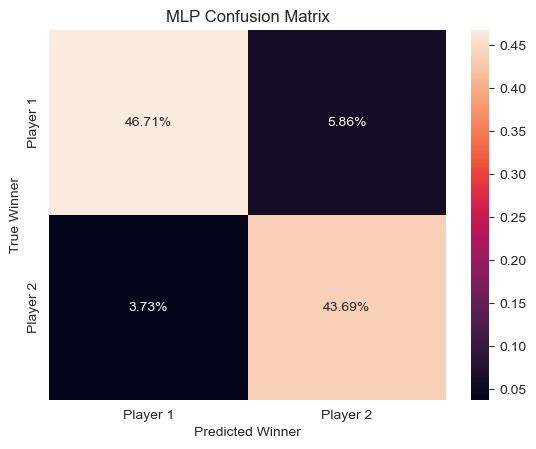

In [47]:
mlp = MLPClassifier(hidden_layer_sizes=[16,12], random_state=42, max_iter=100, learning_rate_init=0.2, activation='logistic')
mlp.fit(X_train_scaled, y_train)
mlp_train_score = mlp.score(X_train_scaled, y_train)
mlp_validation_score = mlp.score(X_val_scaled, y_val)
mlp_test_score = mlp.score(X_test_scaled, y_test)
print('Training accuracy')
print(mlp_train_score)
print('Validation accuracy')
print(mlp_validation_score)
print('Test accuracy')
print(mlp_test_score)

# plot confusion matrix
y_pred = mlp.predict(X_test_scaled)
confusion_matrix_mlp = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.title('MLP Confusion Matrix')
x_labels = ['Player 1', 'Player 2']
y_labels = ['Player 1', 'Player 2']
sns.heatmap(confusion_matrix_mlp / np.sum(confusion_matrix_mlp), fmt='.2%', annot=True, xticklabels=x_labels, yticklabels=y_labels)
plt.ylabel('True Winner')
plt.xlabel('Predicted Winner')


[(0.75, 1.0)]

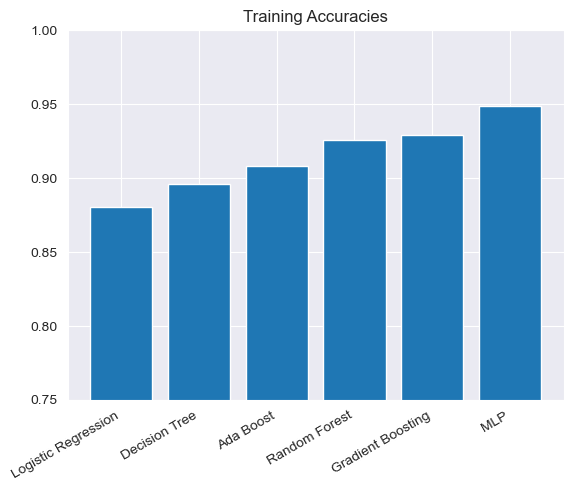

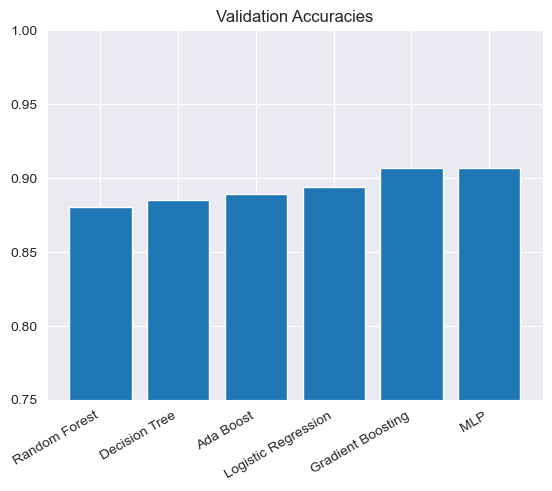

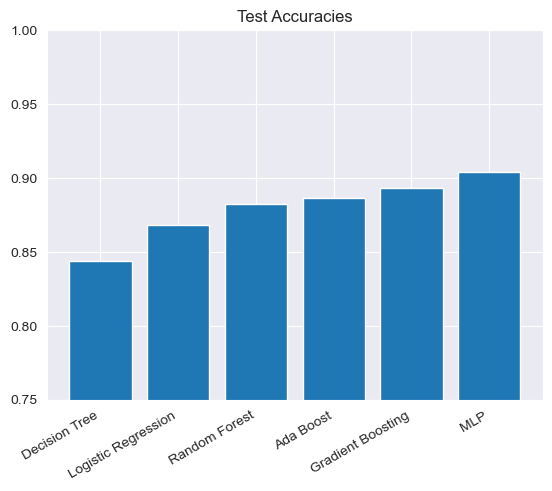

In [65]:
# aggregating best scores:
training_scores_labels = ["Logistic Regression", "Decision Tree", "Ada Boost", "Random Forest", "Gradient Boosting", "MLP"]
training_scores = [log_train_score, adaBoost_train_score, decision_train_score, forest_train_score, mlp_train_score, gradBoost_train_score]
training_scores.sort()

validation_scores = [forest_validation_score, mlp_validation_score, log_validation_score, decision_validation_score, adaBoost_validation_score, gradBoost_validation_score]
validation_scores.sort()
validation_scores_labels = ["Random Forest", "Decision Tree", "Ada Boost", "Logistic Regression", "Gradient Boosting", "MLP"]

test_scores = [forest_test_score, mlp_test_score, decision_test_score, log_test_score, adaBoost_test_score, gradBoost_test_score]
test_scores.sort()
test_scores_labels = ["Decision Tree", "Logistic Regression", "Random Forest", "Ada Boost", "Gradient Boosting", "MLP"]

fig1, ax1 = plt.subplots()
plt.bar(training_scores_labels, training_scores)
plt.title("Training Accuracies")
plt.xticks(rotation=30, ha='right')
ax1.set(ylim=[0.75,1.0])

fig2, ax2 = plt.subplots()
plt.bar(validation_scores_labels, validation_scores)
plt.title("Validation Accuracies")
plt.xticks(rotation=30, ha='right')
ax2.set(ylim=[0.75,1.0])

fig3, ax3 = plt.subplots()
plt.bar(test_scores_labels, test_scores)
plt.title("Test Accuracies")
plt.xticks(rotation=30, ha='right')
ax3.set(ylim=[0.75,1.0])

Text(0.5, 1.0, 'PCA Representation')

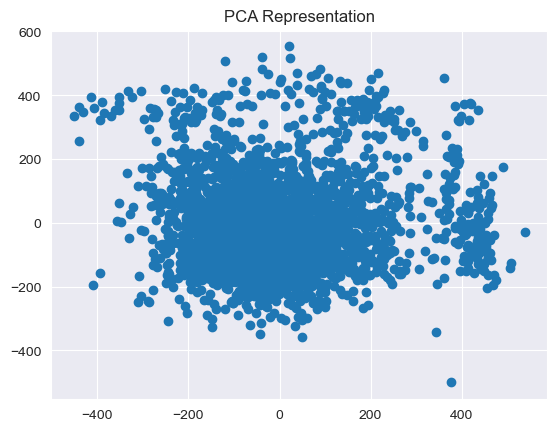

In [77]:
pcaAll = PCA(n_components=2)
X_pca = pcaAll.fit_transform(X)
X_pca = np.transpose(X_pca)
plt.scatter(X_pca[0], X_pca[1])
plt.title("PCA Representation")